# Bot twitter

Este bot genera reportes cada hora y se publican en twitter.

In [1]:
"""
!pip install APIMakeSens
!pip install folium
!pip install tweepy
!pip install selenium
"""

'\n!pip install APIMakeSens\n!pip install folium\n!pip install tweepy\n!pip install selenium\n'

### Cómo ejecutar este código cada hora:

- Descargar el notebook como un archivo .py
- Ejecutar en la terminal watch --interval=3600 python3 ruta/archivo.py

In [1]:
# Librerias
from MakeSens import MakeSens
import numpy as np
import datetime
import pytz
import folium
from folium.plugins import BeautifyIcon

In [2]:
# Rango de fecha
fechaFin = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia
#fechaInicio = fechaFin[:-8]+f'{int(fechaFin[-8:-6])-1:02}'+fechaFin[-6:] # Restar una hora

past_date =  datetime.datetime.now(pytz.timezone('America/Bogota'))- datetime.timedelta(hours=24)  #Restar 24 horas
fechaInicio = past_date.strftime('%Y-%m-%d %H:%M:%S')

print(fechaFin,fechaInicio)

2023-06-15 09:26:25 2023-06-14 09:26:25


In [3]:
# Datos de Estaciones
Estaciones = [('E2_00023','Grupo Halley',7.1393716,-73.1210968),
            ('mE1_00004','Col. Tecnologico',7.1381572,-73.1180935),
            ('mE1_00005','Col. Santander',7.1385332,-73.121327),
            ('mE1_00007','Col. Normal',7.1277056,-73.116534),
            ('mE1_00006','Col. Pilar',7.108717813305484, -73.12173474310134)]

In [4]:
def get_pm25(Estaciones): # Obtener la media de pm25 de las estaciones
    pm25 = []
    Ntotal = int(24*30)
    for est in Estaciones:
        
        data = MakeSens.download_data(est[0],fechaInicio,fechaFin,'m')
        
        if not data.empty: # Revisa que la estación tenga datos en el rango horario indicado
            data.loc[data['pm25_1']>120,'pm25_1']=float("nan") # Eliminar valores mayores a 120
            pm25_1 = np.array(data['pm25_1'].dropna())
            data.loc[data['pm25_2']>120,'pm25_2']=float("nan") # Eliminar valores mayores a 120
            pm25_2 = np.array(data['pm25_2'].dropna())
            Ndata = data['pm25_1'].count()
            if Ndata>0.5*Ntotal:     
                pm25_mean = np.mean([data['pm25_1'].mean(),data['pm25_2'].mean()]) # Media entre la media de ambas columnas de pm25
                pm25.append(pm25_mean)
            else:
                pm25.append(0.0)
        else:
            pm25.append(0.0)
    return pm25

In [5]:
pm25 = get_pm25(Estaciones)

### Mapa con valores de material particulado

In [6]:
# Coordenadas de Bucaramanga, Colombia

# Calcular centro entre estaciones extremas
latitudes = np.array(Estaciones)[:,2].astype('float64')
latitud = (np.max(latitudes)+np.min(latitudes))/2
longitudes = np.array(Estaciones)[:,3].astype('float64')
longitud = (np.max(longitudes)+np.min(longitudes))/2

#latitud = 7.1212675138485695
#longitud = -73.12578300721671

z = int(13-np.log2(10*(np.max(latitudes)-np.min(latitudes)))) # Zoom inicial en el mapa

# Crear el mapa de Bucaramanga con el estilo "CartoDB Positron"
bucaramanga_map = folium.Map(location=[latitud, longitud], 
                              zoom_start=z, tiles='CartoDB Positron',width=677,height=690, zoom_control=False)


def get_color(number):
    if number==0:
        return "#808080"  # Gris
    elif 0 < number <= 12:
        return '#00FF2E'  # Verde
    elif 13 <= number <= 35:
        return '#FFE000'  # Amarillo
    elif 38 <= number <= 55:
        return '#FF6100'  # Naranja
    elif 56 <= number:
        return '#FF0000'  # Rojo

    
for i in range(len(pm25)):
        
        if pm25[i] >= 0.0: # Valor crítico para alerta. Es 0 si se quieren mostrar todas las estaciones
            
            if pm25[i]==0.0:
                valor = 'X'
            else:
                valor = np.round(pm25[i],1)
            # Crear el ícono personalizado con un número
            icon_number = BeautifyIcon(
            border_color=get_color(pm25[i]),
            text_color='#000000',#get_color(pm25[i]),
            number=valor,
            background_color='transparent', # Fondo transparente para que se vean estaciones cercanas entre sí
            icon_size=(40, 40),  # Tamaño del ícono en píxeles
            inner_icon_style='line-height:25px; font-size: 12px;',  # Ajusta el tamaño de la fuente aquí
            spin=True,
            border_width=2,
            )

            # Agregar marcador al mapa
            folium.Marker(
                [Estaciones[i][2], Estaciones[i][3]],
                popup=Estaciones[i][1],
                icon=icon_number
            ).add_to(bucaramanga_map)

bucaramanga_map

### Mapa con ubicaciones de las estaciones

In [7]:
# Coordenadas de Bucaramanga, Colombia

# Calcular centro entre estaciones extremas
latitudes = np.array(Estaciones)[:,2].astype('float64')
latitud = (np.max(latitudes)+np.min(latitudes))/2
longitudes = np.array(Estaciones)[:,3].astype('float64')
longitud = (np.max(longitudes)+np.min(longitudes))/2

#latitud = 7.1212675138485695
#longitud = -73.12578300721671

z = int(13-np.log2(10*(np.max(latitudes)-np.min(latitudes)))) # Zoom inicial en el mapa

# Crear el mapa de Bucaramanga con el estilo "CartoDB Positron"
bucaramanga_map2 = folium.Map(location=[latitud, longitud], 
                              zoom_start=z, tiles='CartoDB Positron',width=677,height=690, zoom_control=False)

    
for i in range(len(pm25)):
            # Crear el ícono personalizado con un número
            icon_number = BeautifyIcon(
            icon_shape='square',
            text_color='#000000',#get_color(pm25[i]),
            number=i+1,
            border_color='#2f5786',
            background_color='transparent', # Fondo transparente para que se vean estaciones cercanas entre sí
            icon_size=(30, 30),  # Tamaño del ícono en píxeles
            inner_icon_style='line-height:20px; font-size: 15px;',  # Ajusta el tamaño de la fuente aquí
            spin=True,
            border_width=2,
            )

            # Agregar marcador al mapa
            folium.Marker(
                [Estaciones[i][2], Estaciones[i][3]],
                popup=Estaciones[i][1],
                icon=icon_number
            ).add_to(bucaramanga_map2)

bucaramanga_map2

Para guardar el mapa como imagen debe tenerse la plantilla en el mismo directorio que este código

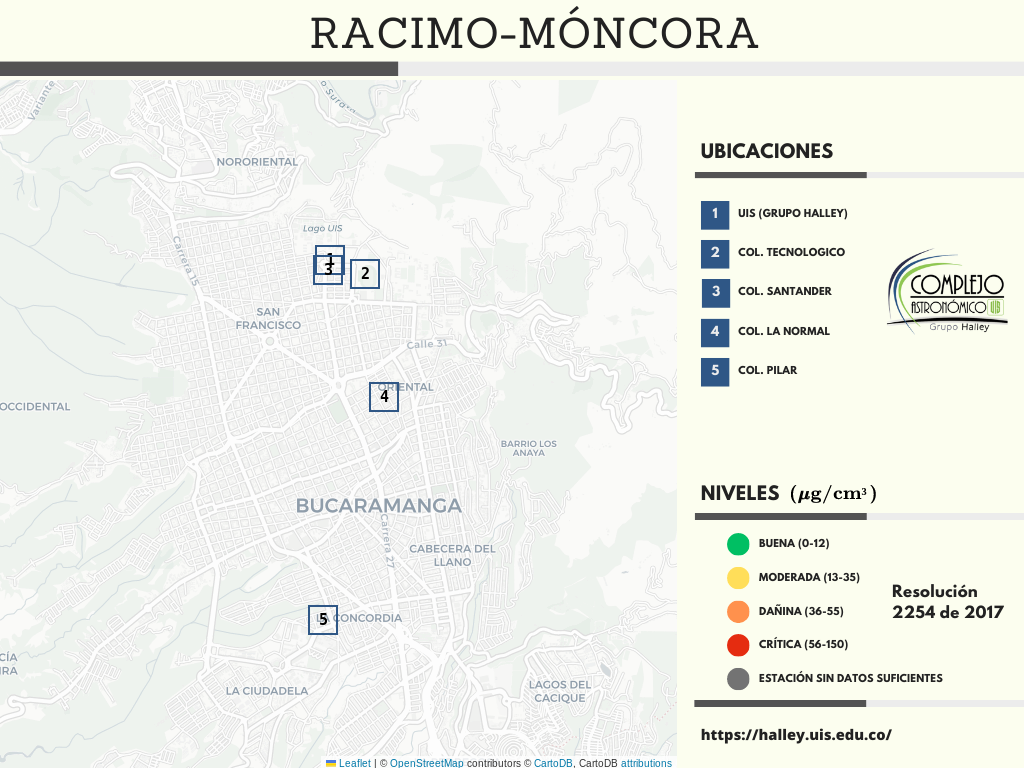

In [8]:
# Convertir mapa a imagen
#bucaramanga_map.save('mapa.html')
#bucaramanga_map2.save('mapa2.html')
import io
from PIL import Image

img_data = bucaramanga_map._to_png(5)
img_data2 = bucaramanga_map2._to_png(5)
img = Image.open(io.BytesIO(img_data))
img2 = Image.open(io.BytesIO(img_data2))


plantilla = Image.open('plantilla.png') # Debe añadirse manualmente en la plantilla las estaciones a mostrar
plantilla.paste(img,(0,80)) # Se une la imagen generada con la plantilla
plantilla.save('mapa_full.png')
plantilla.paste(img2,(0,80)) # Se une la imagen generada con la plantilla
plantilla.save('mapa_full2.png')

plantilla.show()

import os

os.remove('geckodriver.log')

In [9]:
import tweepy

# Llaves de acceso api de twitter

api_key = "HShcrrhB8RkBDziYkUhLYtuJ2"
api_key_secret = "O59rkJfdgpb9mgltXMUqG6mpZRWMY46AzVH7rskY5X1idNRWOi"
access_token= '1667571403778826240-lvL0JpYNAarZfwBbXroLpiYpc7YIYp'
access_token_secret= 'ELC2Y2jhhzzPvwVg0dPNgbfbKdMN8mSkWivQOoprkJqaA'
bearer_token='AAAAAAAAAAAAAAAAAAAAAImjoAEAAAAA9IOPR54QLozTUAmbmUGoQaIIfIw%3Df2egcbl4AtpgBM3aVttbtgggAUPmJrfLH4jZkGRqcDLx7R2uZs'

In [10]:
# Conexión api de twitter

client = tweepy.Client(bearer_token, api_key, api_key_secret, access_token, access_token_secret)
auth = tweepy.OAuth1UserHandler(api_key, api_key_secret, access_token, access_token_secret)
api = tweepy.API(auth)

In [11]:
tweet = f'''#CalidadAireBucaramanga Reporte diario de calidad de aire (material particulado 2.5 mm) {fechaInicio[:10]}.\n
Más información: https://class.redclara.net/halley/moncora/intro.html'''

media = api.media_upload('mapa_full.png')
media2 = api.media_upload('mapa_full2.png')


client.create_tweet(text = tweet, media_ids=[media.media_id_string,media2.media_id_string])

Response(data={'edit_history_tweet_ids': ['1669351431189725186'], 'id': '1669351431189725186', 'text': '#CalidadAireBucaramanga Reporte diario de calidad de aire (material particulado 2.5 mm) 2023-06-14.\n\nMás información: https://t.co/pTchVBDgIs https://t.co/m8kvs1KGkV'}, includes={}, errors=[], meta={})

In [12]:
os.remove("mapa_full.png")
os.remove("mapa_full2.png")